In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow as tf
import os
%matplotlib inline
import shap
import warnings 
warnings.filterwarnings('ignore')

**The code below is adapted from https://github.com/gheisenberg/AML.**

Using the titanic dataset, with predictions of died (0) and survived (1).

In [2]:
train_data = pd.read_csv('data/titanic/train.csv', index_col=0)
test_data = pd.read_csv('data/titanic/test.csv', index_col=0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing
Since the titanic data is a raw data set there is a need to preprocess it by dropping unnecessary columns, handling missing data, converting categorical features to numeric features and conducting one-hot encoding.

In [3]:
def data_preprocessing(df):
    
    df = df.drop(columns=['Name', 'Ticket', 'Cabin']) # unnecessary columns
    
    # fill na - imputation for missing values
    df[['Age']] = df[['Age']].fillna(value=df[['Age']].mean())
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())
    df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())
    
    # encode categorical features into numeric
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    # one-hot encoding
    embarked_one_hot = pd.get_dummies(df['Embarked'], prefix='Embarked')
    
    df = df.drop('Embarked', axis=1)
    df = df.join(embarked_one_hot)
    
    return df

# training data processing
train_data = data_preprocessing(train_data)
train_data.isnull().sum()

# create data for training
x_train = train_data.drop(['Survived'], axis=1).values

# Check testing data
test_data.isnull().sum()

# normalize training data
scale = StandardScaler()
x_train = scale.fit_transform(x_train)

# prepare y_train
y_train = train_data['Survived'].values

# preprocess testing data
test_data = data_preprocessing(test_data)
x_test = test_data.values.astype(float)

# normalize testing data
x_test = scale.transform(x_test)

# Check testing data
test_data.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [4]:
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,0,22.000000,1,0,7.2500,0,0,1
2,1,1,1,38.000000,1,0,71.2833,1,0,0
3,1,3,1,26.000000,0,0,7.9250,0,0,1
4,1,1,1,35.000000,1,0,53.1000,0,0,1
5,0,3,0,35.000000,0,0,8.0500,0,0,1
...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,27.000000,0,0,13.0000,0,0,1
888,1,1,1,19.000000,0,0,30.0000,0,0,1
889,0,3,1,29.699118,1,2,23.4500,0,0,1


In [5]:
x_train

array([[ 0.82737724, -0.73769513, -0.5924806 , ..., -0.48204268,
        -0.30756234,  0.61583843],
       [-1.56610693,  1.35557354,  0.63878901, ...,  2.0745051 ,
        -0.30756234, -1.62380254],
       [ 0.82737724,  1.35557354, -0.2846632 , ..., -0.48204268,
        -0.30756234,  0.61583843],
       ...,
       [ 0.82737724,  1.35557354,  0.        , ..., -0.48204268,
        -0.30756234,  0.61583843],
       [-1.56610693, -0.73769513, -0.2846632 , ...,  2.0745051 ,
        -0.30756234, -1.62380254],
       [ 0.82737724, -0.73769513,  0.17706291, ..., -0.48204268,
         3.25137334, -1.62380254]])

### Build a simple vanilla ANN, compile and fit the model.

In [4]:
tf.keras.utils.set_random_seed(42)

model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit model
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0)

### Now, compute the Shapley values

In [5]:
np.random.seed(47)
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test) # here we get the shap values calculated across the test dataset

In [9]:
len(x_test)

418

In [10]:
len(shap_values[0]) # number of rows

418

In [11]:
len(shap_values[0][0]) # number of features

9

**Below are the Shapley values for every row in the dataset, for each feature in the dataset, hence 418x9.**  
**The two sets of arrays are for each of the two output classes (died=0 and survived=1). So here, they are just inverses of each other, hence we can just ignore the second array.**

In [12]:
shap_values[0]

array([[ 0.05101026,  0.15348056,  0.02420737, ...,  0.00169625,
         0.05975949, -0.01475079],
       [ 0.11331555, -0.24681415,  0.00579464, ...,  0.00065856,
         0.00758301,  0.01002601],
       [-0.00884524,  0.17395837,  0.09609282, ..., -0.00221526,
         0.04024915, -0.0266233 ],
       ...,
       [ 0.04832371,  0.16515172,  0.03574609, ...,  0.00767024,
        -0.00408247,  0.00491293],
       [ 0.04265579,  0.15022437,  0.01364147, ...,  0.00365686,
        -0.00388632,  0.01259931],
       [ 0.0939421 ,  0.1196104 ,  0.01414675, ..., -0.05337427,
        -0.00550811, -0.02737433]])

In [13]:
shap_values[1]

array([[-0.05101027, -0.15348055, -0.02420736, ..., -0.00169625,
        -0.05975947,  0.01475078],
       [-0.11331556,  0.24681419, -0.00579463, ..., -0.00065856,
        -0.00758301, -0.01002601],
       [ 0.00884522, -0.17395837, -0.0960928 , ...,  0.00221526,
        -0.04024915,  0.02662328],
       ...,
       [-0.0483237 , -0.1651516 , -0.03574606, ..., -0.00767024,
         0.00408247, -0.00491292],
       [-0.04265583, -0.15022438, -0.01364147, ..., -0.00365686,
         0.00388633, -0.01259931],
       [-0.09394212, -0.11961041, -0.01414674, ...,  0.05337427,
         0.00550811,  0.02737433]])

### Shapley values interpretation 
#### Global interpretation method

The summary plot shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

**You can turn individual Shapley values into a global explanation, by finding the Shapley value for every datapoint, and then taking the average Shapley value for each feature, across all of the datapoints. This can then find the overall model's feature importances.**

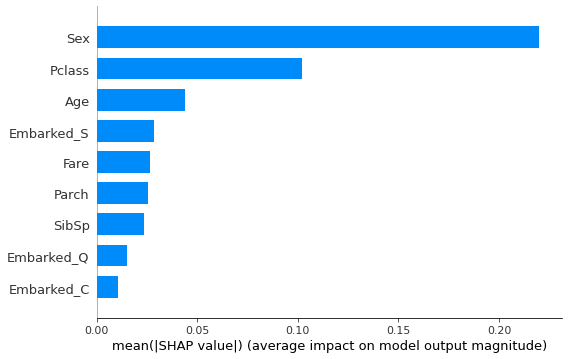

In [14]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test_data.columns)

**For the overall model the sex and class have the greatest impact on the target class "died"**.

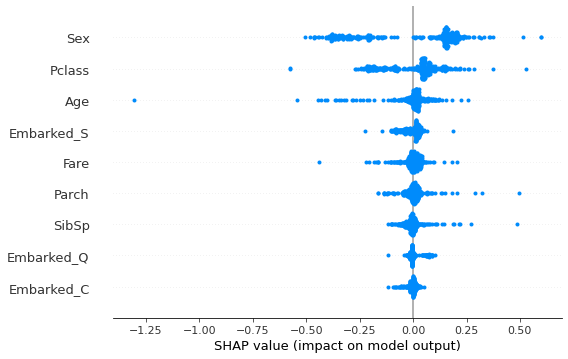

In [15]:
shap.summary_plot(shap_values[0], plot_type = 'dot', feature_names = test_data.columns)

## Local Interpretation methods
### Force plot
The force plot is great for seeing where the “output value” fits in relation to the “base value”. 
Further, it is possible to observe which features have a positive (red) or negative (blue) impact on the prediction and in addition the magnitude of the impact.

In [36]:
pd.Series(x_test[0], index=train_data.columns[1:])

Pclass        0.827377
Sex          -0.737695
Age           0.369449
SibSp        -0.474545
Parch        -0.473674
Fare         -0.490783
Embarked_C   -0.482043
Embarked_Q    3.251373
Embarked_S   -1.623803
dtype: float64

In [35]:
test_data.iloc[0]

Pclass         3.0000
Sex            0.0000
Age           34.5000
SibSp          0.0000
Parch          0.0000
Fare           7.8292
Embarked_C     0.0000
Embarked_Q     1.0000
Embarked_S     0.0000
Name: 892, dtype: float64

In [18]:
model.predict(x_test)[0]

14/14 [==============================] - 0s 3ms/step


array([0.91640675, 0.08359324], dtype=float32)

In [6]:
# this is just looking at the very first observation in the test dataset, [0][0], for the class 0 of died
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.columns)

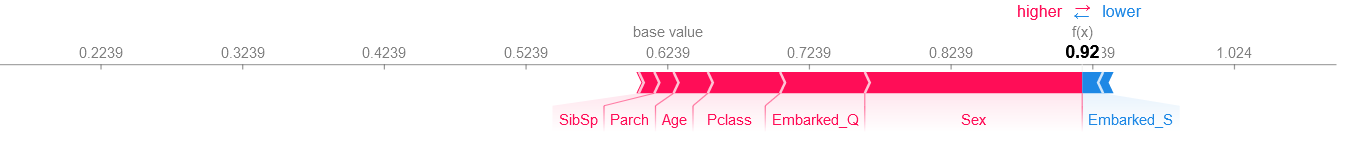

In [20]:
explainer.expected_value[0].numpy() # this is the overall mean average (for class 0, died)

0.62386864

**The prediction for this very first datapoint was 0.916, but the average prediction was 0.624**.   
**The red influences (values on those features) pushed the probability prediction higher than the overall average. The blue influences (features) pushed it lower than the overall average**.  
**What we see here are the difference effects calculated during the Shapley value calculation, NOT the values of the observation on those features**.  
**For example, the fact that sex was 0 (male) caused an increase to the overall probability of class 0 (died).**

In [87]:
pd.Series(shap_values[0][0], index=test_data.columns).sort_values(ascending=False)

Sex           0.152295
Embarked_Q    0.081586
Pclass        0.055505
Age           0.019944
SibSp         0.008538
Embarked_C    0.002528
Fare         -0.000411
Parch        -0.007244
Embarked_S   -0.014743
dtype: float64

**In the overall average, sex and Pclass had the biggest impact on the prediction. However for this individual prediction, Embarked_Q had a larger impact than Pclass.**

### Decision plot
The decision plot enables to observe the amplitude of each change taken by a sample for the values of the displayed features.

**The line is the global average probability. Going from bottom to top, we can see how the inclusion of each feature (in increasing magnitude of Shapley values) contributes to the final decision. e.g. embarked Q has a strong positive addition to the prediction. Embarked S has a weak negative addition to the prediction.**  
**This is the same information as in the force plot, but just in order of size, and cumulative.**

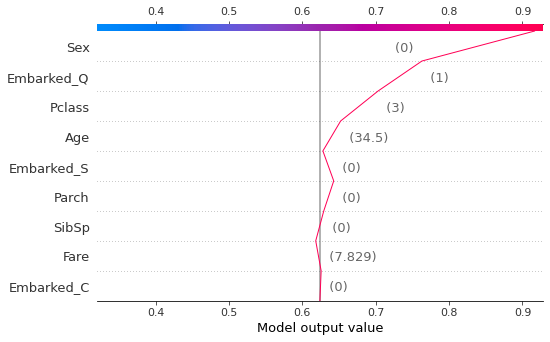

In [41]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.iloc[0, :], 
                   feature_names = test_data.columns.tolist())

### Waterfall plot
The waterfall plot allows for seeing the amplitude and the nature of the impact of a feature. 
It also allows for seeing the order of importance of the features and the values taken by each feature for the sample.

**This is like the force plot, but rather than putting all the features in one line, it stacks them all vertically, with the largest influences on the top.**

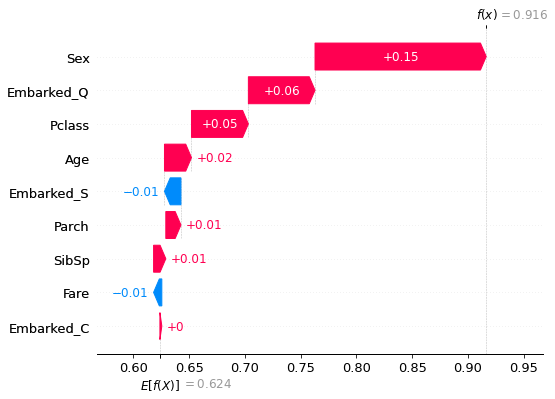

In [40]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], 
                                       feature_names = test_data.columns)

I am using MNIST for my image dataset.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1) / 255
x_test = x_test.reshape(10000, 28, 28, 1) / 255

I create a complex, completely black box convolutional neural network as the model.

In [3]:
tf.keras.utils.set_random_seed(42)
mnist_model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

mnist_model.fit(x_train, y_train, epochs=2, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/2
1875/1875 [==============================] - 180s 95ms/step - loss: 0.1775 - accuracy: 0.9474 - val_loss: 0.0548 - val_accuracy: 0.9816
Epoch 2/2
1875/1875 [==============================] - 175s 94ms/step - loss: 0.0745 - accuracy: 0.9779 - val_loss: 0.0256 - val_accuracy: 0.9908


Only 2 epochs are required to achieve very high accuracy on this model.

I then use only 10 images to generate my Shapley values for, one image for each class.

In [4]:
testing_data = np.asarray([x_test[pd.Series(y_test)[pd.Series(y_test)==class_value].head(1).index[0]] for class_value in range(10)])
predictions = mnist_model.predict(testing_data)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 188ms/step


In [7]:
# the shap library has some bugs with tensorflow - this should fix it
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough

Fitting an explainer to just 1000 datapoints - these will form the "background" that the overall average prediction is calculated upon, and the predictions of each of the individual images will be compared against.

In [8]:
mnist_explainer = shap.DeepExplainer(mnist_model, x_train[:1000])

Calculating the shapley values even for only 10 images took a very long time - this is because finding many differences across many permutations across all of the many features is very computationally expensive.

In [30]:
shap_values = mnist_explainer.shap_values(testing_data)

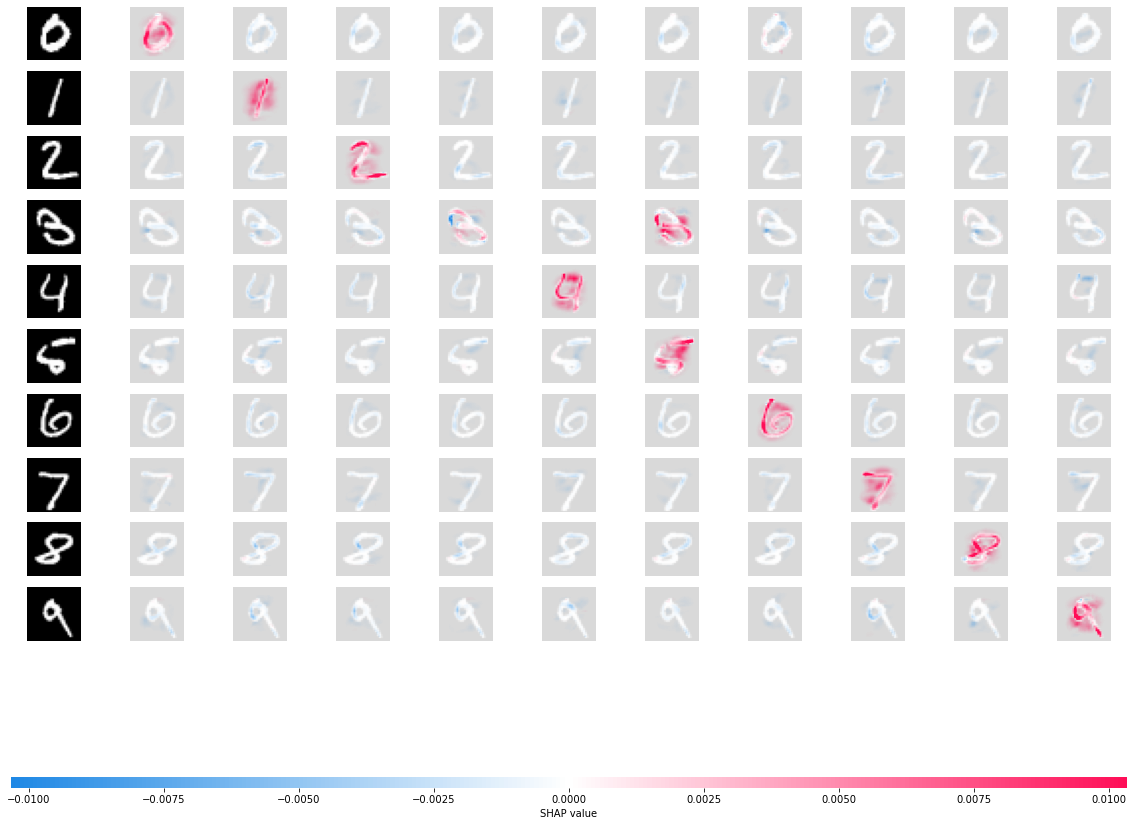

In [13]:
shap.image_plot(shap_values, testing_data)

The plots reveal many red (e.g. positively influencing features/pixels) around the correctly predicted classes. 

For example for the 7, there is a red cluster of pixels to the left of the vertical line in the 7. This suggests that the fact that the image of the 7 had no white marks in this position (only black), positively contributed to the prediction of the class "7". This makes sense - for many of the other classes, such as the 2 or 6, there would have been a white line in that position.

The blue pixels on the negatively predicted classes indicate the aspects of the image which reduced the probability of the corresponding class.

The number 3 was incorrectly predicted to be a number 5. The semi-circle to the right of the 3, highlighted in red, it shown to have had a "positive" influence in the prediction of a 5.

With image data, the force plots and waterfall plots cannot be created. As each feature just represents a pixel, these plots would not be very readable.